In [1]:
dataset = "iris"

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
feature_A = "bmi"

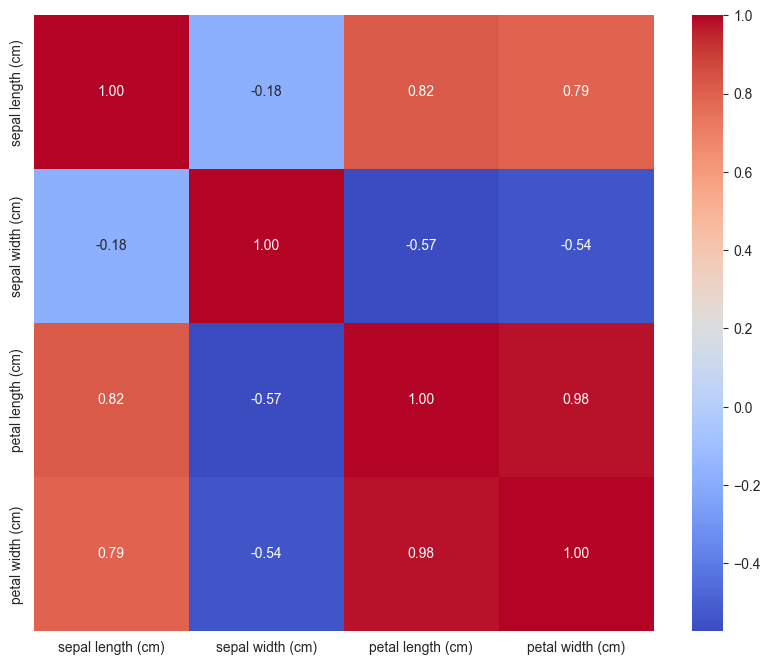

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from Dashboard.data_preprocessing import load_and_preprocess_data


X_train, X_test, y_train, y_test, task = load_and_preprocess_data("iris")

# Then calculate the correlation matrix
correlation_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()



## Experiment 1

Train F1 Score: 1.0, Test F1 Score: 1.0


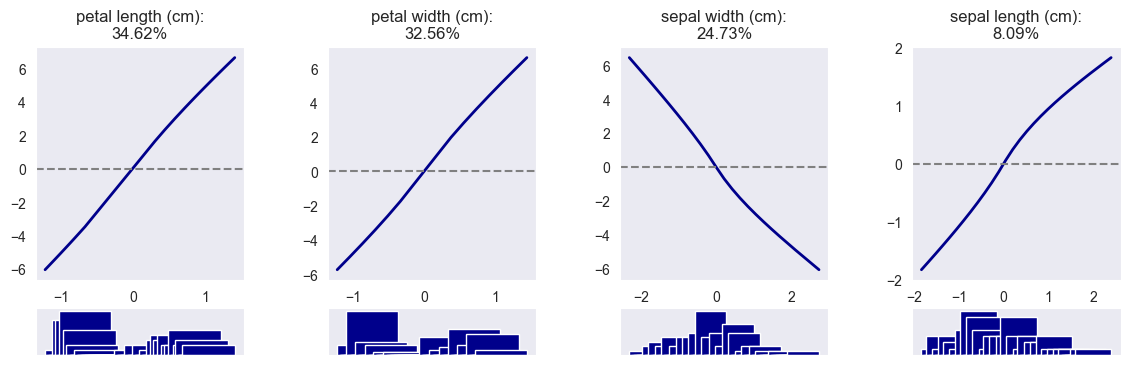

In [8]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score

X_train, X_test, y_train, y_test, task = load_and_preprocess_data("iris")
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

adapter.model.plot_single(show_n=5)



In [12]:
# Assumption: BMI has an effect on BP
# Step 1: Get predictions for feature_1 (BMI)

feature_1 = "petal length (cm)"
shape_functions_dict = adapter.model.get_shape_functions_as_dict()

i = adapter.model.feature_names.index(feature_1)
feat_values = np.array(X_train[feature_1])
#adapter.model._get_pred_feature_1_of_i(i, np.array(X_train))
#y = torch.tensor(updated_data[feature]['y'], dtype=torch.float64)
if adapter.model.task == "classification":
    pred_feature_1 = adapter.model.init_classifier.coef_[0, i] * feat_values
else:
    pred_feature_1 = adapter.model.init_classifier.coef_[i] * feat_values

if isinstance(pred_feature_1, np.ndarray):
    pred_feature_1 = torch.from_numpy(pred_feature_1).float()

for regressor, boost_rate in zip(adapter.model.regressors, adapter.model.boosting_rates):
    pred_feature_1 += (
        boost_rate
        * regressor.predict_single(torch.tensor(feat_values.reshape(-1, 1), dtype=torch.float), i).squeeze()
    ).cpu()
print(pred_feature_1)

tensor([ 5.4737,  4.2635, -4.4515, -5.4101,  3.6388, -4.7735, -5.4101,  4.5705,
        -4.7735,  6.6459, -4.4515, -5.0929,  5.4737, -5.0929,  1.6438, -4.1267,
         5.4737,  5.1753, -5.7250, -5.4101, -5.0929, -4.7735, -4.7735,  4.5705,
        -4.7735, -4.7735,  2.9968, -4.4515,  3.9531, -6.0382, -3.4672, -4.7735,
        -5.0929, -5.4101, -5.0929,  5.4737, -5.0929,  2.6682, -5.4101,  3.9531,
         6.0637,  4.2635,  5.7697, -4.4515,  6.0637,  4.2635, -4.4515,  5.4737,
         4.5705,  4.8743,  2.3336, -5.4101,  5.7697, -4.7735,  0.5438,  1.6438,
         5.1753, -4.7735,  4.5705,  3.6388,  6.0637,  5.4737, -5.0929, -4.4515,
        -5.0929,  6.6459, -4.7735, -5.4101, -4.1267,  5.1753,  5.7697,  4.8743,
         6.0637,  3.6388, -4.1267,  2.3336,  3.9531, -5.7250,  3.9531,  5.4737])


In [15]:
# Since it is a classification task, we need to rescale the predictions for feature 1
# Min-max normalization
min_val, max_val = pred_feature_1.min(), pred_feature_1.max()
normalized_pred_feature_1 = (pred_feature_1 - min_val) / (max_val - min_val)

# Scaling to -1 to 1
scaled_pred_feature_1 = normalized_pred_feature_1 * 2 - 1
normalized_pred_feature_1

tensor([0.9076, 0.8122, 0.1251, 0.0495, 0.7629, 0.0997, 0.0495, 0.8364, 0.0997,
        1.0000, 0.1251, 0.0745, 0.9076, 0.0745, 0.6056, 0.1507, 0.9076, 0.8841,
        0.0247, 0.0495, 0.0745, 0.0997, 0.0997, 0.8364, 0.0997, 0.0997, 0.7123,
        0.1251, 0.7877, 0.0000, 0.2027, 0.0997, 0.0745, 0.0495, 0.0745, 0.9076,
        0.0745, 0.6864, 0.0495, 0.7877, 0.9541, 0.8122, 0.9309, 0.1251, 0.9541,
        0.8122, 0.1251, 0.9076, 0.8364, 0.8603, 0.6600, 0.0495, 0.9309, 0.0997,
        0.5189, 0.6056, 0.8841, 0.0997, 0.8364, 0.7629, 0.9541, 0.9076, 0.0745,
        0.1251, 0.0745, 1.0000, 0.0997, 0.0495, 0.1507, 0.8841, 0.9309, 0.8603,
        0.9541, 0.7629, 0.1507, 0.6600, 0.7877, 0.0247, 0.7877, 0.9076])

In [13]:
# Step 2: Adjust overall predictions by subtracting the predictions of feature_1
# usually, scaled_pred_feature_1 needs to be used, but datset wasn't scaled to -1,1 initially
#y_train_adjusted = y_train - np.array(normalized_pred_feature_1)
y_train_adjusted = y_train - np.array(pred_feature_1)
# Prepare new X column
X_train_except_feat_1 = X_train.drop(columns=[feature_1])

In [29]:
y_train

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [14]:
y_train_adjusted

array([-4.47366285, -3.26349258,  4.4514904 ,  5.41005754, -2.63875532,
        4.77348089,  5.41005754, -3.57047272,  4.77348089, -5.6458745 ,
        4.4514904 ,  5.09293604, -4.47366285,  5.09293604, -0.64382851,
        4.12667608, -4.47366285, -4.17527437,  5.7250371 ,  5.41005754,
        5.09293604,  4.77348089,  4.77348089, -3.57047272,  4.77348089,
        4.77348089, -1.99682355,  4.4514904 , -2.95305991,  6.03815699,
        3.46723461,  4.77348089,  5.09293604,  5.41005754,  5.09293604,
       -4.47366285,  5.09293604, -1.66818166,  5.41005754, -2.95305991,
       -5.0636735 , -3.26349258, -4.76972342,  4.4514904 , -5.0636735 ,
       -3.26349258,  4.4514904 , -4.47366285, -3.57047272, -3.87427711,
       -1.33361435,  5.41005754, -4.76972342,  4.77348089,  0.45616663,
       -0.64382851, -4.17527437,  4.77348089, -3.57047272, -2.63875532,
       -5.0636735 , -4.47366285,  5.09293604,  4.4514904 ,  5.09293604,
       -5.6458745 ,  4.77348089,  5.41005754,  4.12667608, -4.17

In [15]:
X_train_except_feat_1['sepal length (cm)']

55    0.358663
88    0.202042
26   -0.737687
42   -1.677417
69    0.202042
        ...   
60   -0.737687
71    0.985149
14    0.515285
92    0.515285
51    1.455014
Name: sepal length (cm), Length: 80, dtype: float64

In [32]:
y_train_adjusted

array([ 0.09241635,  0.18782532, -0.12509166, -0.04951891,  0.23707914,
       -0.09970616, -0.04951891,  0.16362321, -0.09970616,  0.        ,
       -0.12509166, -0.07452054,  0.09241635, -0.07452054,  0.39435774,
       -0.15069979,  0.09241635,  0.11594105, -0.02468615, -0.04951891,
       -0.07452054, -0.09970616, -0.09970616,  0.16362321, -0.09970616,
       -0.09970616,  0.28768855, -0.12509166,  0.21229959,  0.        ,
       -0.20268969, -0.09970616, -0.07452054, -0.04951891, -0.07452054,
        0.09241635, -0.07452054,  0.31359845, -0.04951891,  0.21229959,
        0.04590029,  0.18782532,  0.06907511, -0.12509166,  0.04590029,
        0.18782532, -0.12509166,  0.09241635,  0.16362321,  0.1396715 ,
        0.33997554, -0.04951891,  0.06907511, -0.09970616,  0.48108059,
        0.39435774,  0.11594105, -0.09970616,  0.16362321,  0.23707914,
        0.04590029,  0.09241635, -0.07452054, -0.12509166, -0.07452054,
        0.        , -0.09970616, -0.04951891, -0.15069979,  0.11

In [18]:
# Step 3:
# Retrain all other features with y_train_adjusted
adapter_adjusted_feat_1 = ModelAdapter(task)
adapter_adjusted_feat_1.fit(X_train_except_feat_1, np.array(normalized_pred_feature_1))
y_train_pred_adjusted= adapter_adjusted_feat_1.predict(X_train_except_feat_1)
task = "classification"
# if task == "regression":
#     mse_train_adjusted_feat_1 = mean_squared_error(y_train_adjusted, y_train_pred_adjusted)
#     print(f"MSE Train: {mse_train_adjusted_feat_1}")
# else:
#     f1_train_adjusted_feat_1 = f1_score(y_train_adjusted, y_train_pred_adjusted, average='weighted')
#     print(f"Train F1 Score: {f1_train_adjusted_feat_1}")

adapter_adjusted_feat_1.model.plot_single(show_n=5)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [14]:
# Metrics to quantify the change
if task == "regression":
    main_metric = mse_train - mse_train_adjusted_feat_1
else:
    main_metric = f1_train - f1_train_adjusted_feat_1
print(f"Differenz in MSE or f1: {main_metric}")
shape_functions_dict_adjusted_feat_1 = adapter_adjusted_feat_1.get_shape_functions_as_dict()

correlations_with_feature_1 = correlation_matrix[feature_1]
correlations_with_feature_1 = correlations_with_feature_1.drop(feature_1)
results_columns = ['metadata'] + list(correlations_with_feature_1.index)  # Correlation indices as columns
results_df = pd.DataFrame(columns=results_columns)
results_df.loc[0] = ["Correlations"] + correlations_with_feature_1.tolist()



comparison_results = []

# Iterate through the original dictionary
for original_feature in shape_functions_dict:
    # Skip 'bmi' feature
    if original_feature['name'] == feature_1:
        continue
    
    # Find corresponding feature in the adjusted dictionary
    adjusted_feature = next((item for item in shape_functions_dict_adjusted_feat_1 if item['name'] == original_feature['name']), None)
    
    # Continue if the feature is not found in the adjusted dictionary
    if not adjusted_feature:
        continue
    
    # Calculate average of y values for both features
    avg_y_original = sum(original_feature['y']) / len(original_feature['y'])
    avg_y_adjusted = sum(adjusted_feature['y']) / len(adjusted_feature['y'])
    
    # Calculate the most distant points by finding the maximum absolute difference between corresponding y values
    max_diff = max(abs(o - a) for o, a in zip(original_feature['y'], adjusted_feature['y']))
    
    # Compare avg_effect
    avg_effect_diff = adjusted_feature['avg_effect'] - original_feature['avg_effect']
    
    # Store the comparison results
    comparison_results.append({
        'feature': original_feature['name'],
        'avg_y_original': avg_y_original,
        'avg_y_adjusted': avg_y_adjusted,
        'max_diff_y': max_diff,
        'avg_effect_diff': avg_effect_diff,
    })

new_row = {'metadata': 'Avg Effect Diff'}
max_diff_row = {'metadata': 'Max Diff Y'}

for result in comparison_results:
    feature = result['feature']
    avg_effect_diff = result['avg_effect_diff']
    max_diff = result['max_diff_y']
    new_row[feature] = avg_effect_diff
    max_diff_row[feature] = max_diff
    # For features not in comparison_results, set to None or another placeholder value
    for col in results_df.columns:
        if col not in new_row:
            new_row[col] = None
        if col not in max_diff_row:
            max_diff_row[col] = None
new_row_df = pd.DataFrame([new_row])
max_diff_row_df = pd.DataFrame([max_diff_row])

# Append the new row to the DataFrame
results_df = pd.concat([results_df, new_row_df], ignore_index=True)
results_df = pd.concat([results_df, max_diff_row_df], ignore_index=True)
results_df
dataset="blood_pressure"
effect="no_effect"


path = os.path.join(os.getcwd(), f"freeze_weights_{dataset}_{effect}.csv")

results_df.to_csv(path, decimal=',', index=False)

Differenz in MSE or f1: 0.004121599780344709


## Experiment 2

MSE Train: 0.47059960764395203, MSE Test: 0.4547642929721244


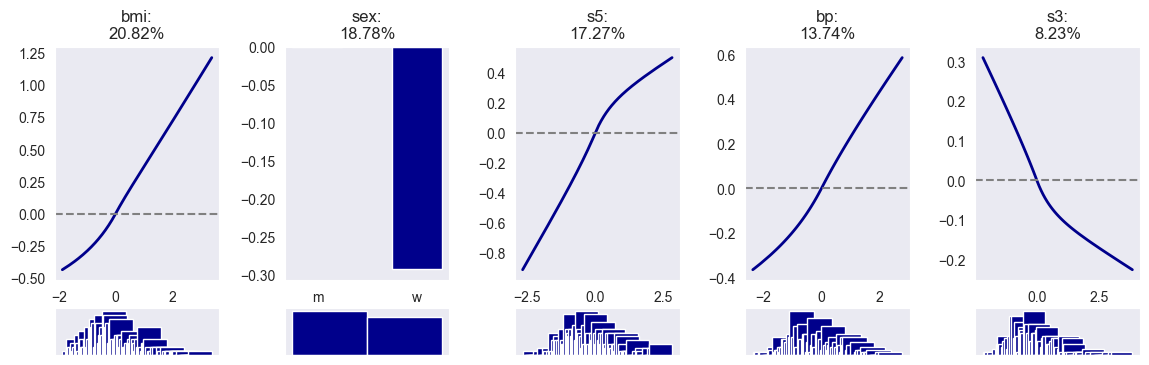

In [16]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score

X_train, X_test, y_train, y_test, task = load_and_preprocess_data()
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

adapter.model.plot_single(show_n=5)



C:\Users\jfill\PycharmProjects\Masterthesis\Dashboard\model_adapter.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat = torch.tensor(y_hat, dtype=torch.float32)


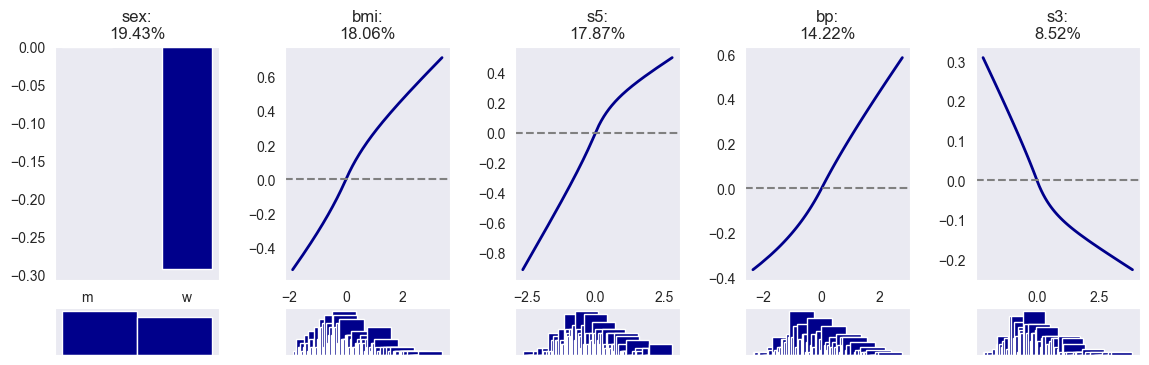

In [20]:
# Step 1: Adjust weights for feature_1 (BMI
# We cut off the positive effect at 0.5

features_to_change = ['bmi']
shape_functions_dict = adapter.model.get_shape_functions_as_dict()

# this part is already given in the flask application
feature_current_state = {}
for feature in shape_functions_dict:
    name = feature['name']
    y_value = feature['y']
    feature_current_state[name] = y_value

updated_data = {}

for feature in shape_functions_dict:
    name = feature['name']
    x_values = feature['x']
    if name in features_to_change:
        # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
        if feature["datatype"] == "numerical":
            y_values = np.where(np.array(feature_current_state[name]) > 0.5, 0.5, feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': y_values.tolist(), 'datatype': 'numerical'}       
        else:
            y_values = np.array(feature_current_state[name])
            #updated_data[name] = {'x': x_values, 'y': np.array([-2]), 'datatype': 'categorical'}
            updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'categorical'}
    else:
        if feature['datatype'] == 'numerical':
            updated_data[name] = {'x': x_values, 'y': feature['y'].tolist(), 'datatype': 'numerical'}
        else:
            updated_data[name] = {'x': x_values, 'y': feature['y'], 'datatype': 'categorical'}
            #y_values = feature_current_state[name]
#spline, retrain_feature
adapter = adapter.adapt(features_to_change, updated_data, "retrain_feature", X_train, y_train)
adapter.plot_single(show_n=5)


In [26]:
# Assumption: BMI has an effect on BP
# Step 2: Get predictions for feature_1 (BMI)

feature_1 = "bmi"
shape_functions_dict = adapter.get_shape_functions_as_dict()

i = adapter.feature_names.index(feature_1)
feat_values = np.array(X_train[feature_1])
#adapter.model._get_pred_feature_1_of_i(i, np.array(X_train))
#y = torch.tensor(updated_data[feature]['y'], dtype=torch.float64)
if adapter.task == "classification":
    pred_feature_1 = adapter.init_classifier.coef_[0, i] * feat_values
else:
    pred_feature_1 = adapter.init_classifier.coef_[i] * feat_values

if isinstance(pred_feature_1, np.ndarray):
    pred_feature_1 = torch.from_numpy(pred_feature_1).float()

for regressor, boost_rate in zip(adapter.regressors, adapter.boosting_rates):
    pred_feature_1 += (
        boost_rate
        * regressor.predict_single(torch.tensor(feat_values.reshape(-1, 1), dtype=torch.float), i).squeeze()
    ).cpu()
print(pred_feature_1)

tensor([ 0.0866, -0.1309,  0.2857, -0.2394, -0.4073, -0.2648,  0.1392,  0.3688,
         0.2303, -0.1237, -0.4242,  0.1329, -0.3671,  0.5081, -0.4795,  0.1392,
        -0.2711, -0.2394, -0.2896,  0.1329,  0.1694, -0.2458,  0.2509, -0.3260,
         0.3095,  0.1003, -0.0866, -0.0789, -0.0712, -0.0314,  0.1070,  0.1575,
        -0.2522, -0.2200,  0.1266, -0.1164, -0.0476,  0.0651, -0.2522, -0.0712,
        -0.4686, -0.0149, -0.2958,  0.2660,  0.2034,  0.4336, -0.0789,  0.5284,
        -0.0476,  0.0105,  0.5445, -0.2711,  0.1202,  0.3282, -0.3019,  0.2759,
         0.0425, -0.2134,  0.3048, -0.0395, -0.0712,  0.1635,  0.5963,  0.1003,
        -0.0064, -0.2134,  0.0347,  0.0724, -0.2134, -0.2585,  0.0187, -0.1800,
        -0.4129, -0.2648, -0.3079, -0.2200,  0.0187,  0.2660, -0.3496, -0.2585,
        -0.1164, -0.0866, -0.5282, -0.1800,  0.1515,  0.3373, -0.0555,  0.4123,
         0.3328,  0.3142, -0.1800,  0.0347,  0.0502, -0.1935, -0.3079, -0.0314,
        -0.2648, -0.4073,  0.3732,  0.17

MSE Train: 0.4741471747688996


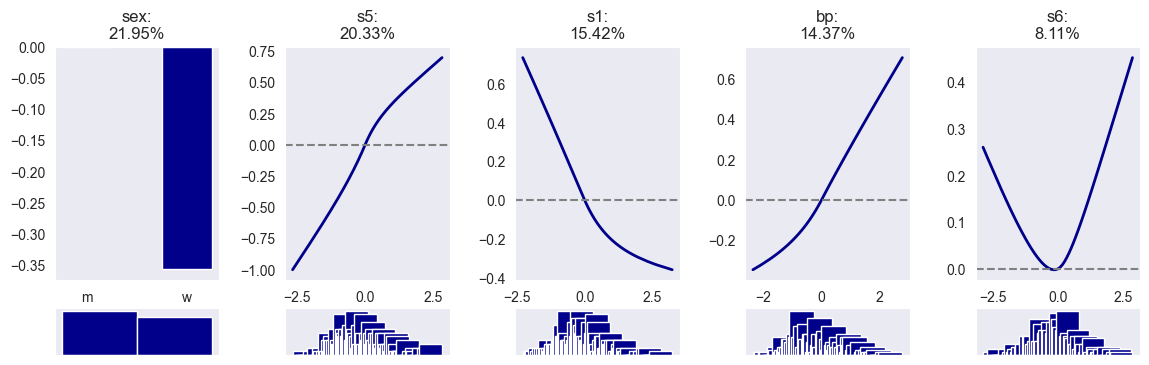

In [28]:
# Step 2: Adjust overall predictions by subtracting the predictions of feature_1
y_train_adjusted = y_train - np.array(pred_feature_1)
# Prepare new X column
X_train_except_feat_1 = X_train.drop(columns=[feature_1])
# Step 3:
# Retrain all other features with y_train_adjusted
adapter_adjusted_feat_1 = ModelAdapter(task)
adapter_adjusted_feat_1.fit(X_train_except_feat_1, y_train_adjusted)
y_train_pred_adjusted = adapter_adjusted_feat_1.predict(X_train_except_feat_1)
if task == "regression":
    mse_train_adjusted_feat_1 = mean_squared_error(y_train_adjusted, y_train_pred_adjusted)
    print(f"MSE Train: {mse_train_adjusted_feat_1}")
else:
    f1_train_adjusted_feat_1 = f1_score(y_train_adjusted, y_train_pred_adjusted, average='weighted')
    print(f"Train F1 Score: {f1_train_adjusted_feat_1}")

adapter_adjusted_feat_1.model.plot_single(show_n=5)

In [29]:
# Metrics to quantify the change
if task == "regression":
    main_metric = mse_train - mse_train_adjusted_feat_1
else:
    main_metric = f1_train - f1_train_adjusted_feat_1
print(f"Differenz in MSE or f1: {main_metric}")
shape_functions_dict_adjusted_feat_1 = adapter_adjusted_feat_1.get_shape_functions_as_dict()

correlations_with_feature_1 = correlation_matrix[feature_1]
correlations_with_feature_1 = correlations_with_feature_1.drop(feature_1)
results_columns = ['metadata'] + list(correlations_with_feature_1.index)  # Correlation indices as columns
results_df = pd.DataFrame(columns=results_columns)
results_df.loc[0] = ["Correlations"] + correlations_with_feature_1.tolist()



comparison_results = []

# Iterate through the original dictionary
for original_feature in shape_functions_dict:
    # Skip 'bmi' feature
    if original_feature['name'] == feature_1:
        continue
    
    # Find corresponding feature in the adjusted dictionary
    adjusted_feature = next((item for item in shape_functions_dict_adjusted_feat_1 if item['name'] == original_feature['name']), None)
    
    # Continue if the feature is not found in the adjusted dictionary
    if not adjusted_feature:
        continue
    
    # Calculate average of y values for both features
    avg_y_original = sum(original_feature['y']) / len(original_feature['y'])
    avg_y_adjusted = sum(adjusted_feature['y']) / len(adjusted_feature['y'])
    
    # Calculate the most distant points by finding the maximum absolute difference between corresponding y values
    max_diff = max(abs(o - a) for o, a in zip(original_feature['y'], adjusted_feature['y']))
    
    # Compare avg_effect
    avg_effect_diff = adjusted_feature['avg_effect'] - original_feature['avg_effect']
    
    # Store the comparison results
    comparison_results.append({
        'feature': original_feature['name'],
        'avg_y_original': avg_y_original,
        'avg_y_adjusted': avg_y_adjusted,
        'max_diff_y': max_diff,
        'avg_effect_diff': avg_effect_diff,
    })

new_row = {'metadata': 'Avg Effect Diff'}
max_diff_row = {'metadata': 'Max Diff Y'}

for result in comparison_results:
    feature = result['feature']
    avg_effect_diff = result['avg_effect_diff']
    max_diff = result['max_diff_y']
    new_row[feature] = avg_effect_diff
    max_diff_row[feature] = max_diff
    # For features not in comparison_results, set to None or another placeholder value
    for col in results_df.columns:
        if col not in new_row:
            new_row[col] = None
        if col not in max_diff_row:
            max_diff_row[col] = None
new_row_df = pd.DataFrame([new_row])
max_diff_row_df = pd.DataFrame([max_diff_row])

# Append the new row to the DataFrame
results_df = pd.concat([results_df, new_row_df], ignore_index=True)
results_df = pd.concat([results_df, max_diff_row_df], ignore_index=True)
results_df
dataset="diabetes"
effect="with_effec"


path = os.path.join(os.getcwd(), f"freeze_weights_{dataset}_{effect}.csv")

results_df.to_csv(path, decimal=',', index=False)

Differenz in MSE or f1: -0.0035475671249475815
